# Visualization of assignment 2 results
This notebook visualizes some of the results that our pipeline for assignment 2 yields.  
Most notably, we're interested in whether there is a difference in valence (positive/negative/neutral) in tweets about this year's two US presidential candidates: Donald Trump and Joe Biden.

In [2]:
# Imports
import google.auth  #1.22.1
from google.cloud import bigquery  #2.2.0
from google.cloud import bigquery_storage  #2.0.1
import matplotlib.pyplot as plt  #3.3.2
import numpy as np  #1.19.2
import os
import pandas as pd  #1.1.4

In [3]:
# Authorization for Google Cloud Platform
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="dataengineering-course-a9365e622cc2.json"

credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Creating the right clients to access BigQuery
bqclient = bigquery.Client(credentials=credentials, project='dataengineering-course',)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [4]:
# Creating a pandas dataframe based on an SQL query in BigQuery
query_string = "SELECT * FROM `dataengineering-course.US_election_data.tweet_info`"

dataframe = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient))

df = pd.DataFrame(dataframe)
df.head()

,user_id,tweet,sentiment_label,compound_score,time_stamp,candidate
0,@SylviaLehmann6,kirstiealley trump is the worse president the ...,neg,-0.648600000,2020-10-22 09:52:20,Trump
1,@KristinAGroh2,funder jaxs thank u scottwe must focus on bide...,pos,0.945100000,2020-10-22 10:04:33,Biden
2,@LBHickman,ive lost all faith in realdonaldtrump no secon...,neg,-0.915300000,2020-10-22 09:51:04,Both
3,@IShallResist,marcorubio and you will support the fraud clai...,neg,-0.526700000,2020-10-22 09:54:04,Trump
4,@ChrisFi78250835,skynewsaust senatormcgrath well every poll had...,pos,0.511800000,2020-10-22 09:58:58,Trump


## Checking the sentiment analysis model
Let's see if the sentiment analysis makes sense.  
Are tweets correctly classified as either positive or negative?

We print the three most negative and positive tweets in the dataset, to see if we agree with the model

In [5]:
df['compound_score'] = pd.to_numeric(df['compound_score'])

print("Most negative tweets:")
for t in df.nsmallest(3, 'compound_score')['tweet']:
    print(t + ";")
    print()

print("Most positive tweets:")
for t in df.nlargest(3, 'compound_score')['tweet']:
    print(t + ";")
    print()

Most negative tweets:
trump spews hate unrelentingly like a hurt spoil disturbed child as a sociopath who really doesnt care and should hell is an unimaginable evil or hate without love of darkest of hate eternally where god or love doesnt exist unlike life beware trump hell exist vote;

trump spews hate unrelentingly like a hurt spoil disturbed child as a sociopath who really doesnt care and should hell is an unimaginable evil or hate without love of darkest of hate eternally where god or love doesnt exist unlike life beware trump hell exist vote;

racism is evil and those who cause violence in its name are criminals and thugs including the kkk neonazis white supremacists and other hate groups trump aug ;

Most positive tweets:
sadiececile why because president trump is the best candidate for our economy for jobs for minorities and people support his causes we live in america the land of freedom this is not china or cuba iam a proud american and i support trumppence amp i only wish th

#### Conclusion:  
The sentiment analysis seems to qualify tweets well.

## Checking the valence of tweets per candidate
The use case of our pipeline wants to know what kind of valence the tweets about a certain presidential candidate have, and how this compares to that of the other candidate.  
Below, we will plot a graph showing this, as well as a baseline that checks the valence of tweets that mention both candidates

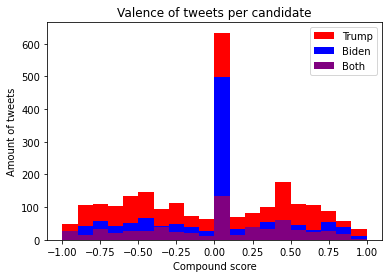

In [6]:
binwidth = 0.1
bins = np.arange(-1, 1 + binwidth, binwidth)

plt.hist(df[df['candidate'] == 'Trump']['compound_score'], color='red', label='Trump', bins=bins)
plt.hist(df[df['candidate'] == 'Biden']['compound_score'], color='blue', label='Biden', bins=bins)
plt.hist(df[df['candidate'] == 'Both']['compound_score'], color='purple', label='Both', bins=bins)

plt.title('Valence of tweets per candidate')
plt.xlabel('Compound score')
plt.ylabel('Amount of tweets')
plt.legend(loc='best')

plt.show()

#### Conclusion
We see that there is no large difference in the valence of the tweets per candidate. However, we do see that there is a clear difference in how much is tweeted about a certain candidate. Donald Trump is definitely more often mentioned than Joe Biden. Independent of political preference, this should come as no surprise.

## Fun additional analysis
We were also curious if the emotion that is present in the tweet has an effect on the length of the text. One could hypothesize that people that are angry type less long tweets.  
We try to find out if there is a correlation between length and valence below.

In [7]:
# add the length of the tweet to the dataframe
df['tlength'] = df['tweet'].str.len()

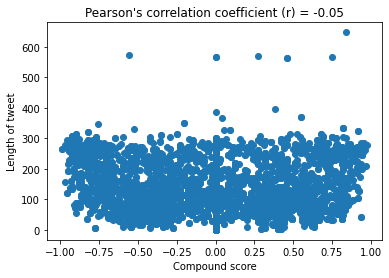

In [11]:
r = round(df['tlength'].corr(df['compound_score']), 2)

plt.scatter(df['compound_score'], df['tlength'])
plt.title(f"Pearson's correlation coefficient (r) = {r}")
plt.xlabel('Compound score')
plt.ylabel('Length of tweet')
plt.show()

#### Conclusion
It is probably safe to conclude that there is no correlation between tweet length and valence in our dataset.